# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [73]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [76]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [77]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [78]:
 # define your regions here
presel = {
    
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>300) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
#             "tagger>0.5": "fj_ParT_score_finetuned>0.5",

            ### signal region
#             "LepIsolation": " ( (lep_pt<55) & (lep_isolation<0.15) ) | (lep_pt>=55)",
#             "LepMisolation": " ( (lep_pt>=55) & (lep_misolation<0.2) ) | (lep_pt<55)",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>300) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
#             "tagger>0.5": "fj_ParT_score_finetuned>0.5",            
            
            ### signal region
#             "LepIsolation": " ( (lep_pt<120) & (lep_isolation<0.15) ) | (lep_pt>=120)",
        },
}

from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

years = ["2017", "2016", "2016APV", "2018"]

In [9]:
### new corrections
samples_dir = {
    "2016":    "../eos/postprocessNov12_2016",
    "2016APV": "../eos/postprocessNov12_2016APV",
    "2017":    "../eos/postprocessNov12_2017",
    "2018":    "../eos/postprocessNov12_2018",
}
events_dict = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict = {**events_dict, **out}

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3841 events
INFO:root:Applying lep_fj_dr08 selection on 3841 events
INFO:root:Applying fj_pt300 selection on 3841 events
INFO:root:Applying dphi<1.57 selection on 67 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4 events
INFO:root:tot event weight 5.742591831366373 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 362 events
INFO:root:Applying lep_fj_dr08 selection on 362 events
INFO:root:Applying fj_pt300 selection on 362 events
INFO:root:Applying dphi<1.57 selection on 71 events
INFO:root:Will fill the DYJets dataframe with the remaining 28 events
INFO:root:tot event weight 490.12402608825226 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should co

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 129307 events
INFO:root:Applying lep_fj_dr08 selection on 129307 events
INFO:root:Applying fj_pt300 selection on 129307 events
INFO:root:Applying dphi<1.57 selection on 118177 events
INFO:root:Will fill the DYJets dataframe with the remaining 72837 events
INFO:root:tot event weight 673.6484138946835 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 921 events
INFO:root:Applying lep_fj_dr08 selection on 921 events
INFO:root:Applying fj_pt300 selection on 921 events
INFO:root:Applying dphi<1.57 selection on 220 events
INFO:root:Will fill the VBF dataframe with the remaining 146 events
INFO:root:tot event weight 6.062193975858574 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event we

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 156188 events
INFO:root:Applying lep_fj_dr08 selection on 156188 events
INFO:root:Applying fj_pt300 selection on 156188 events
INFO:root:Applying dphi<1.57 selection on 135692 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 105758 events
INFO:root:tot event weight 4800.3936180852925 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 866757 events
INFO:root:Applying lep_fj_dr08 selection on 866757 events
INFO:root:Applying fj_pt300 selection on 866757 events
INFO:root:Applying dphi<1.57 selection on 332276 events
INFO:root:Will fill the TTbar dataframe with the remaining 237637 events
INFO:root:tot event weight 27266.946855383816 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored 

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 197217 events
INFO:root:Applying lep_fj_dr08 selection on 197217 events
INFO:root:Applying fj_pt300 selection on 197217 events
INFO:root:Applying dphi<1.57 selection on 183730 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 145798 events
INFO:root:tot event weight 1490.1803489445622 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 111330 events
INFO:root:Applying lep_fj_dr08 selection on 111330 events
INFO:root:Applying fj_pt300 selection on 111330 events
INFO:root:Applying dphi<1.57 selection on 5873 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3497 events
INFO:root:tot event weight 1304.3611489595532 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Usin

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 107043 events
INFO:root:Applying lep_fj_dr08 selection on 107043 events
INFO:root:Applying fj_pt300 selection on 107043 events
INFO:root:Applying dphi<1.57 selection on 28972 events
INFO:root:Will fill the Data dataframe with the remaining 14581 events
INFO:root:tot event weight 14581.0 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 47719 events
INFO:root:Applying lep_fj_dr08 selection on 47719 events
INFO:root:Applying fj_pt300 selection on 47719 events
INFO:root:Applying dphi<1.57 selection on 13103 events
INFO:root:Will fill the Data dataframe with the remaining 6642 events
INFO:root:tot event weight 6642.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:No parquet file for WJetsToLNu_HT-70To100
INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:No parquet file for 

INFO:root:Applying fj_pt300 selection on 1567 events
INFO:root:Applying dphi<1.57 selection on 1381 events
INFO:root:Will fill the QCD dataframe with the remaining 576 events
INFO:root:tot event weight 7603.786024764824 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2396 events
INFO:root:Applying lep_fj_dr08 selection on 2396 events
INFO:root:Applying fj_pt300 selection on 2396 events
INFO:root:Applying dphi<1.57 selection on 2102 events
INFO:root:Will fill the WZQQ dataframe with the remaining 912 events
INFO:root:tot event weight 95.36544061424402 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ


Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1058 events
INFO:root:Applying lep_fj_dr08 selection on 1058 events
INFO:root:Applying fj_pt300 selection on 1058 events
INFO:root:Applying dphi<1.57 selection on 625 events
INFO:root:Will fill the WZQQ dataframe with the remaining 235 events
INFO:root:tot event weight 29.786680620364173 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 128874 events
INFO:root:Applying lep_fj_dr08 selection on 128874 events
INFO:root:Applying fj_pt300 selection on 128874 events
INFO:root:Applying dphi<1.57 selection on 92579 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 68071 events
INFO:root:tot event weight 6517.877689495522 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1583 events
INFO:root:Applying lep_fj_dr08 selection on 1583 events
INFO:root:Applying fj_pt300 selection on 1583 events
INFO:root:Applying dphi<1.57 selection on 996 events
INFO:root:Will fill the WZQQ dataframe with the remaining 417 events
INFO:root:tot event weight 134.40961658871151 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event wei

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 57465 events
INFO:root:Applying lep_fj_dr08 selection on 57465 events
INFO:root:Applying fj_pt300 selection on 57465 events
INFO:root:Applying dphi<1.57 selection on 54791 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 42714 events
INFO:root:tot event weight 37.10113914434725 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11238 events
INFO:root:Applying lep_fj_dr08 selection on 11238 events
INFO:root:Applying fj_pt300 selection on 11238 events
INFO:root:Applying dphi<1.57 selection on 4739 events
INFO:root:Will fill the ttH dataframe with the remaining 2970 events
INFO:root:tot event weight 9.927446293637141 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1308 events
I

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 275765 events
INFO:root:Applying lep_fj_dr08 selection on 275765 events
INFO:root:Applying fj_pt300 selection on 275765 events
INFO:root:Applying dphi<1.57 selection on 49893 events
INFO:root:Will fill the DYJets dataframe with the remaining 24312 events
INFO:root:tot event weight 1316.7298541713594 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017F
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4407 events
INFO:root:Applying lep_fj_dr08 selection on 4407 events
INFO:root:Applying fj_pt300 selection on 4407 events
INFO:root:Applying dphi<1.57 selection on 74 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5 events
INFO:root:tot event weight 6.3899134575293175 

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 23063 events
INFO:root:Applying lep_fj_dr08 selection on 23063 events
INFO:root:Applying fj_pt300 selection on 23063 events
INFO:root:Applying dphi<1.57 selection on 19323 events
INFO:root:Will fill the DYJets dataframe with the remaining 13603 events
INFO:root:tot event weight 129.7537458804786 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1426 events
INFO:root:Applying lep_fj_dr08 selection on 1426 events
INFO:root:Applying fj_pt300 selection on 1426 events
INFO:root:Applying dphi<1.57 selection on 405 events
INFO:root:Will fill the VBF dataframe with the remaining 312 events
INFO:root:tot event weight 12.92205239542422 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 213045 events
INFO:root:Applying lep_fj_dr08 selection on 213045 events
INFO:root:Applying fj_pt300 selection on 213045 events
INFO:root:Applying dphi<1.57 selection on 186200 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 146888 events
INFO:root:tot event weight 6941.314318719092 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 943577 events
INFO:root:Applying lep_fj_dr08 selection on 943577 events
INFO:root:Applying fj_pt300 selection on 943577 events
INFO:root:Applying dphi<1.57 selection on 355014 events
INFO:root:Will fill the TTbar dataframe with the remaining 254863 events
INFO:root:tot event weight 29119.31817529 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 270374 events
INFO:root:Applying lep_fj_dr08 selection on 270374 events
INFO:root:Applying fj_pt300 selection on 270374 events
INFO:root:Applying dphi<1.57 selection on 253351 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 204730 events
INFO:root:tot event weight 2174.5606193005096 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 138315 events
INFO:root:Applying lep_fj_dr08 selection on 138315 events
INFO:root:Applying fj_pt300 selection on 138315 events
INFO:root:Applying dphi<1.57 selection on 6300 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3789 events
INFO:root:tot event weight 1485.6086476552564 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Usin

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 91731 events
INFO:root:Applying lep_fj_dr08 selection on 91731 events
INFO:root:Applying fj_pt300 selection on 91731 events
INFO:root:Applying dphi<1.57 selection on 23837 events
INFO:root:Will fill the Data dataframe with the remaining 15157 events
INFO:root:tot event weight 15157.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 36615 events
INFO:root:Applying lep_fj_dr08 selection on 36615 events
INFO:root:Applying fj_pt300 selection on 36615 events
INFO:root:Applying dphi<1.57 selection on 17245 events
INFO:root:Will fill the SingleTop dataframe with the remaining 12349 events
INFO:root:tot event weight 35.37237087463976 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:Apply

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 811 events
INFO:root:Applying lep_fj_dr08 selection on 811 events
INFO:root:Applying fj_pt300 selection on 811 events
INFO:root:Applying dphi<1.57 selection on 537 events
INFO:root:Will fill the QCD dataframe with the remaining 376 events
INFO:root:tot event weight 4871.561723681063 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1106 events
INFO:root:Applying lep_fj_dr08 selection on 1106 events
INFO:root:Applying fj_pt300 selection on 1106 events
INFO:root:Applying dphi<1.57 selection on 886 events
INFO:root:Will fill the WZQQ dataframe with the remaining 652 events
INFO:root:tot event weight 65.55525762337803 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 997 events
INFO:root:Applying lep_fj_dr08 selection on 997 events
INFO:root:Applying fj_pt300 selection on 997 events
INFO:root:Applying dphi<1.57 selection on 370 events
INFO:root:Will fill the WZQQ dataframe with the remaining 258 events
INFO:root:tot event weight 33.45853031998887 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 175965 events
INFO:root:Applying lep_fj_dr08 selection on 175965 events
INFO:root:Applying fj_pt300 selection on 175965 events
INFO:root:Applying dphi<1.57 selection on 124975 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 92023 events
INFO:root:tot event weight 9276.608088961597 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 682 events
INFO:root:Applying lep_fj_dr08 selection on 682 events
INFO:root:Applying fj_pt300 selection on 682 events
INFO:root:Applying dphi<1.57 selection on 263 events
INFO:root:Will fill the WZQQ dataframe with the remaining 169 events
INFO:root:tot event weight 41.44314896724559 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 77865 events
INFO:root:Applying lep_fj_dr08 selection on 77865 events
INFO:root:Applying fj_pt300 selection on 77865 events
INFO:root:Applying dphi<1.57 selection on 74965 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 59972 events
INFO:root:tot event weight 53.348177692547196 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10498 events
INFO:root:Applying lep_fj_dr08 selection on 10498 events
INFO:root:Applying fj_pt300 selection on 10498 events
INFO:root:Applying dphi<1.57 selection on 4675 events
INFO:root:Will fill the ttH dataframe with the remaining 3067 events
INFO:root:tot event weight 10.316637668003281 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1250 events

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 199435 events
INFO:root:Applying lep_fj_dr08 selection on 199435 events
INFO:root:Applying fj_pt300 selection on 199435 events
INFO:root:Applying dphi<1.57 selection on 31747 events
INFO:root:Will fill the DYJets dataframe with the remaining 17742 events
INFO:root:tot event weight 945.1394033528582 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 134578 events
INFO:root:Applying lep_fj_dr08 selection on 134578 events
INFO:root:Applying fj_pt300 selection on 134578 events
INFO:root:Applying dphi<1.57 selection on 34268 events
INFO:root:Will fill the Data dataframe with the remaining 21364 events
INFO:root:tot event weight 21364.0 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1145 e

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 125157 events
INFO:root:Applying lep_fj_dr08 selection on 125157 events
INFO:root:Applying fj_pt300 selection on 125157 events
INFO:root:Applying dphi<1.57 selection on 112562 events
INFO:root:Will fill the DYJets dataframe with the remaining 69701 events
INFO:root:tot event weight 276.70121652631747 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 452 events
INFO:root:Applying lep_fj_dr08 selection on 452 events
INFO:root:Applying fj_pt300 selection on 452 events
INFO:root:Applying dphi<1.57 selection on 96 events
INFO:root:Will fill the VBF dataframe with the remaining 62 events
INFO:root:tot event weight 2.21304040965813 

INFO:root:Finding SingleMuon_Run2016G samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 63781 events
INFO:root:Applying lep_fj_dr08 selection on 63781 events
INFO:root:Applying fj_pt300 selection on 63781 events
INFO:root:Applying dphi<1.57 selection on 55347 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 43709 events
INFO:root:tot event weight 1879.175616234387 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 75025 events
INFO:root:Applying lep_fj_dr08 selection on 75025 events
INFO:root:Applying fj_pt300 selection on 75025 events
INFO:root:Applying dphi<1.57 selection on 28112 events
INFO:root:Will fill the TTbar dataframe with the remaining 20327 events
INFO:root:tot event weight 10271.047732460376 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 79345 events
INFO:root:Applying lep_fj_dr08 selectio

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 55 events
INFO:root:Applying lep_fj_dr08 selection on 55 events
INFO:root:Applying fj_pt300 selection on 55 events
INFO:root:Applying dphi<1.57 selection on 6 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight


Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 10095 events
INFO:root:Applying lep_fj_dr08 selection on 10095 events
INFO:root:Applying fj_pt300 selection on 10095 events
INFO:root:Applying dphi<1.57 selection on 5027 events
INFO:root:Will fill the SingleTop dataframe with the remaining 3600 events
INFO:root:tot event weight 10.841982725555658 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 20179 events
INFO:root:Applying lep_fj_dr08 selection on 20179 events
INFO:root:Applying fj_pt300 selection on 20179 events
INFO:root:Applying dphi<1.57 selection on 3602 events
INFO:root:Will fill the DYJets dataframe with the remaining 1616 events
INFO:root:tot event weight 100.3465534108903 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1039 e

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1129 events
INFO:root:Applying lep_fj_dr08 selection on 1129 events
INFO:root:Applying fj_pt300 selection on 1129 events
INFO:root:Applying dphi<1.57 selection on 966 events
INFO:root:Will fill the WZQQ dataframe with the remaining 444 events
INFO:root:tot event weight 45.138218354993896 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 624 events
INFO:root:Applying lep_fj_dr08 selection on 624 events
INFO:root:Applying fj_pt300 selection on 624 events
INFO:root:Applying dphi<1.57 selection on 327 events
INFO:root:Will fill the WZQQ dataframe with the remaining 136 events
INFO:root:tot event weight 13.181341724872595 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 49996 events
INFO:root:Applying lep_fj_dr08 selection on 49996 events
INFO:root:Applying fj_pt300 selection on 49996 events
INFO:root:Applying dphi<1.57 selection on 35364 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 26163 events
INFO:root:tot event weight 2506.3706550377174 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 761 events
INFO:root:Applying lep_fj_dr08 selection on 761 events
INFO:root:Applying fj_pt300 selection on 761 events
INFO:root:Applying dphi<1.57 selection on 439 events
INFO:root:Will fill the WZQQ dataframe with the remaining 191 events
INFO:root:tot event weight 35.57951188153804 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 33311 

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 10323 events
INFO:root:Applying lep_fj_dr08 selection on 10323 events
INFO:root:Applying fj_pt300 selection on 10323 events
INFO:root:Applying dphi<1.57 selection on 4302 events
INFO:root:Will fill the ttH dataframe with the remaining 2775 events
INFO:root:tot event weight 4.068222770224807 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 767 events
INFO:root:Applying lep_fj_dr08 selection on 767 events
INFO:root:Applying fj_pt300 selection on 767 events
INFO:root:Applying dphi<1.57 selection on 667 events
INFO:root:Will fill the WZQQ dataframe with the remaining 321 events
INFO:root:tot event weight 18.363457524217694 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5202 events
INFO:root:App

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 259992 events
INFO:root:Applying lep_fj_dr08 selection on 259992 events
INFO:root:Applying fj_pt300 selection on 259992 events
INFO:root:Applying dphi<1.57 selection on 42325 events
INFO:root:Will fill the DYJets dataframe with the remaining 20346 events
INFO:root:tot event weight 431.76556319730184 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1273 events
INFO:root:Applying lep_fj_dr08 selection on 1273 events
INFO:root:Applying fj_pt300 selection on 1273 events
INFO:root:Applying dphi<1.57 selection on 31 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data


Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 78929 events
INFO:root:Applying lep_fj_dr08 selection on 78929 events
INFO:root:Applying fj_pt300 selection on 78929 events
INFO:root:Applying dphi<1.57 selection on 20366 events
INFO:root:Will fill the Data dataframe with the remaining 12982 events
INFO:root:tot event weight 12982.0 

INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 3808 events
INFO:root:Applying lep_fj_dr08 selection on 3808 events
INFO:root:Applying fj_pt300 selection on 3808 events
INFO:root:Applying dphi<1.57 selection on 1001 events
INFO:root:Will fill the Data dataframe with the remaining 635 events
INFO:root:tot event weight 635.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 23470 events
INFO:root:Applying lep_fj_dr08 selection on 23470 events
INFO:root:App

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 92490 events
INFO:root:Applying lep_fj_dr08 selection on 92490 events
INFO:root:Applying fj_pt300 selection on 92490 events
INFO:root:Applying dphi<1.57 selection on 80231 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 63819 events
INFO:root:tot event weight 2831.128441063691 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 87877 events
INFO:root:Applying lep_fj_dr08 selection on 87877 events
INFO:root:Applying fj_pt300 selection on 87877 events
INFO:root:Applying dphi<1.57 selection on 32129 events
INFO:root:Will fill the TTbar dataframe with the remaining 23281 events
INFO:root:tot event weight 11420.898913805191 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Will fill the SingleTop dataframe with the remaining 5086 events
INFO:root:tot event weight 15.272390301428437 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 23982 events
INFO:root:Applying lep_fj_dr08 selection on 23982 events
INFO:root:Applying fj_pt300 selection on 23982 events
INFO:root:Applying dphi<1.57 selection on 4472 events
INFO:root:Will fill the DYJets dataframe with the remaining 2121 events
INFO:root:tot event weight 148.8396386259666 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 461 events
INFO:root:Applying lep_fj_dr08 selection on 461 events
INFO:root:Applying fj_pt300 selection on 461 events
INFO:root:Applying dphi<1.57 selection on 454 events
INFO:root:Will fill the QCD dataframe with the remaining 3

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 4707 events
INFO:root:Applying lep_fj_dr08 selection on 4707 events
INFO:root:Applying fj_pt300 selection on 4707 events
INFO:root:Applying dphi<1.57 selection on 4495 events
INFO:root:Will fill the QCD dataframe with the remaining 3506 events
INFO:root:tot event weight 132.65053449751605 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2585 events
INFO:root:Applying lep_fj_dr08 selection on 2585 events
INFO:root:Applying fj_pt300 selection on 2585 events
INFO:root:Applying dphi<1.57 selection on 1664 events
INFO:root:Will fill the QCD dataframe with the remaining 1181 events
INFO:root:tot event weight 2358.7573598161007 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 551 events
INFO:root:App

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 73761 events
INFO:root:Applying lep_fj_dr08 selection on 73761 events
INFO:root:Applying fj_pt300 selection on 73761 events
INFO:root:Applying dphi<1.57 selection on 51318 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 37979 events
INFO:root:tot event weight 3713.5318034852894 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 400 events
INFO:root:Applying lep_fj_dr08 selection on 400 events
INFO:root:Applying fj_pt300 selection on 400 events
INFO:root:Applying dphi<1.57 selection on 156 events
INFO:root:Will fill the WZQQ dataframe with the remaining 102 events
INFO:root:tot event weight 18.123101283103278 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
I

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying fj_pt300 selection on 48459 events
INFO:root:Applying dphi<1.57 selection on 46663 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 37518 events
INFO:root:tot event weight 22.060675512427665 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10484 events
INFO:root:Applying lep_fj_dr08 selection on 10484 events
INFO:root:Applying fj_pt300 selection on 10484 events
INFO:root:Applying dphi<1.57 selection on 4485 events
INFO:root:Will fill the ttH dataframe with the remaining 3010 events
INFO:root:tot event weight 4.183903345792388 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 782 events
INFO:root:Applying lep_fj_dr08 selection on 782 events
INFO:root:Applying fj_pt300 selection on 782 events
INFO:root

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 187926 events
INFO:root:Applying lep_fj_dr08 selection on 187926 events
INFO:root:Applying fj_pt300 selection on 187926 events
INFO:root:Applying dphi<1.57 selection on 29429 events
INFO:root:Will fill the DYJets dataframe with the remaining 16378 events
INFO:root:tot event weight 370.9003267713395 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1272 events
INFO:root:Applying lep_fj_dr08 selection on 1272 events
INFO:root:Applying fj_pt300 selection on 1272 events
INFO:root:Applying dphi<1.57 selection on 21 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets


Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 133624 events
INFO:root:Applying lep_fj_dr08 selection on 133624 events
INFO:root:Applying fj_pt300 selection on 133624 events
INFO:root:Applying dphi<1.57 selection on 120278 events
INFO:root:Will fill the DYJets dataframe with the remaining 72841 events
INFO:root:tot event weight 304.8887892834359 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 421 events
INFO:root:Applying lep_fj_dr08 selection on 421 events
INFO:root:Applying fj_pt300 selection on 421 events
INFO:root:Applying dphi<1.57 selection on 89 events
INFO:root:Will fill the VBF dataframe with the remaining 60 events
INFO:root:tot event weight 2.5187724896386507 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event wei

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 71245 events
INFO:root:Applying lep_fj_dr08 selection on 71245 events
INFO:root:Applying fj_pt300 selection on 71245 events
INFO:root:Applying dphi<1.57 selection on 61488 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 48312 events
INFO:root:tot event weight 2029.0525315603593 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 90915 events
INFO:root:Applying lep_fj_dr08 selection on 90915 events
INFO:root:Applying fj_pt300 selection on 90915 events
INFO:root:Applying dphi<1.57 selection on 33901 events
INFO:root:Will fill the TTbar dataframe with the remaining 24643 events
INFO:root:tot event weight 10931.869094166519 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 7

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:Applying lep_fj_dr003 selection on 77435 events
INFO:root:Applying lep_fj_dr08 selection on 77435 events
INFO:root:Applying fj_pt300 selection on 77435 events
INFO:root:Applying dphi<1.57 selection on 71952 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 57606 events
INFO:root:tot event weight 620.3058749831815 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 40308 events
INFO:root:Applying lep_fj_dr08 selection on 40308 events
INFO:root:Applying fj_pt300 selection on 40308 events
INFO:root:Applying dphi<1.57 selection on 1730 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1033 events
INFO:root:tot event weight 420.6302400871682 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr0

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 25395 events
INFO:root:Applying lep_fj_dr08 selection on 25395 events
INFO:root:Applying fj_pt300 selection on 25395 events
INFO:root:Applying dphi<1.57 selection on 6742 events
INFO:root:Will fill the Data dataframe with the remaining 3376 events
INFO:root:tot event weight 3376.0 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11010 events
INFO:root:Applying lep_fj_dr08 selection on 11010 events
INFO:root:Applying fj_pt300 selection on 11010 events
INFO:root:Applying dphi<1.57 selection on 2069 events
INFO:root:Will fill the DYJets dataframe with the remaining 873 events
INFO:root:tot event weight 128.19122388069775 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 946 events
INFO:root:Ap

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying fj_pt300 selection on 42553 events
INFO:root:Applying dphi<1.57 selection on 11377 events
INFO:root:Will fill the Data dataframe with the remaining 5647 events
INFO:root:tot event weight 5647.0 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6524 events
INFO:root:Applying lep_fj_dr08 selection on 6524 events
INFO:root:Applying fj_pt300 selection on 6524 events
INFO:root:Applying dphi<1.57 selection on 6262 events
INFO:root:Will fill the QCD dataframe with the remaining 2692 events
INFO:root:tot event weight 141.1086366285178 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4348 events
INFO:root:Applying lep_fj_dr08 selection on 4348 events
INFO:root:Applying fj_pt300 selection on 4348 events
INFO:root:Applying dphi<1.57 sele

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 49939 events
INFO:root:Applying lep_fj_dr08 selection on 49939 events
INFO:root:Applying fj_pt300 selection on 49939 events
INFO:root:Applying dphi<1.57 selection on 35120 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 26073 events
INFO:root:tot event weight 2744.6085737503518 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 25541 events
INFO:root:Applying lep_fj_dr08 selection on 25541 events
INFO:root:Applying fj_pt300 selection on 25541 events
INFO:root:Applying dphi<1.57 selection on 6753 events
INFO:root:Will fill the Data dataframe with the remaining 3374 events
INFO:root:tot event weight 3374.0 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1222 events
INFO:root:Applying lep_fj_dr08 selection on 1

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 8732 events
INFO:root:Applying lep_fj_dr08 selection on 8732 events
INFO:root:Applying fj_pt300 selection on 8732 events
INFO:root:Applying dphi<1.57 selection on 3656 events
INFO:root:Will fill the ttH dataframe with the remaining 2411 events
INFO:root:tot event weight 4.476730287996047 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 518 events
INFO:root:Applying lep_fj_dr08 selection on 518 events
INFO:root:Applying fj_pt300 selection on 518 events
INFO:root:Applying dphi<1.57 selection on 428 events
INFO:root:Will fill the WZQQ dataframe with the remaining 172 events
INFO:root:tot event weight 14.753052042402075 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4416 events
INFO:root:Applyi

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 262038 events
INFO:root:Applying lep_fj_dr08 selection on 262038 events
INFO:root:Applying fj_pt300 selection on 262038 events
INFO:root:Applying dphi<1.57 selection on 42345 events
INFO:root:Will fill the DYJets dataframe with the remaining 20090 events
INFO:root:tot event weight 471.15112645259023 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1391 events
INFO:root:Applying lep_fj_dr08 selection on 1391 events
INFO:root:Applying fj_pt300 selection on 1391 events
INFO:root:Applying dphi<1.57 selection on 26 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 657 events
INFO:root:Applying lep_fj_dr08 selection on 657 events
INFO:root:Applying fj_pt300 selection on 657 events
INFO:root:Applying dphi<1.57 selection on 128 events
INFO:root:Will fill the VBF dataframe with the remaining 96 events
INFO:root:tot event weight 3.918398095562641 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5281 events
INFO:root:Applying lep_fj_dr08 selection on 5281 events
INFO:root:Applying fj_pt300 selection on 5281 events
INFO:root:Applying dphi<1.57 selection on 1566 events
INFO:root:Will fill the VH dataframe with the remaining 1197 events
INFO:root:tot event weight 0.8931862201783072 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 105815 events
INFO:root:Applying lep_fj_dr08 selection on 105815 events
INFO:root:Applying fj_pt300 selection on 105815 events
INFO:root:Applying dphi<1.57 selection on 91754 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 72861 events
INFO:root:tot event weight 3152.113615755196 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 107586 events
INFO:root:Applying lep_fj_dr08 selection on 107586 events
INFO:root:Applying fj_pt300 selection on 107586 events
INFO:root:Applying dphi<1.57 selection on 38865 events
INFO:root:Will fill the TTbar dataframe with the remaining 28168 events
INFO:root:tot event weight 12435.957552748043 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 116504 events
INFO:root:Applying lep_fj_dr08 selection on 116504 events
INFO:root:Applying fj_pt300 selection on 116504 events
INFO:root:Applying dphi<1.57 selection on 109148 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 88727 events
INFO:root:tot event weight 986.8133116889696 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 52559 events
INFO:root:Applying lep_fj_dr08 selection on 52559 events
INFO:root:Applying fj_pt300 selection on 52559 events
INFO:root:Applying dphi<1.57 selection on 1869 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1122 events
INFO:root:tot event weight 451.8266917996981 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using alre

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6569 events
INFO:root:Applying lep_fj_dr08 selection on 6569 events
INFO:root:Applying fj_pt300 selection on 6569 events
INFO:root:Applying dphi<1.57 selection on 2082 events
INFO:root:Will fill the VH dataframe with the remaining 1586 events
INFO:root:tot event weight 1.5904413676561173 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 74 events
INFO:root:Applying lep_fj_dr08 selection on 74 events
INFO:root:Applying fj_pt300 selection on 74 events
INFO:root:Applying dphi<1.57 selection on 5 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying l

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 3829 events
INFO:root:Applying lep_fj_dr08 selection on 3829 events
INFO:root:Applying fj_pt300 selection on 3829 events
INFO:root:Applying dphi<1.57 selection on 3655 events
INFO:root:Will fill the QCD dataframe with the remaining 2865 events
INFO:root:tot event weight 147.09291387672306 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2414 events
INFO:root:Applying lep_fj_dr08 selection on 2414 events
INFO:root:Applying fj_pt300 selection on 2414 events
INFO:root:Applying dphi<1.57 selection on 1547 events
INFO:root:Will fill the QCD dataframe with the remaining 1090 events
INFO:root:tot event weight 2499.954797225003 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 890 events
INFO:root:Appl

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 49339 events
INFO:root:Applying lep_fj_dr08 selection on 49339 events
INFO:root:Applying fj_pt300 selection on 49339 events
INFO:root:Applying dphi<1.57 selection on 12944 events
INFO:root:Will fill the Data dataframe with the remaining 8409 events
INFO:root:tot event weight 8409.0 

INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 33898 events
INFO:root:Applying lep_fj_dr08 selection on 33898 events
INFO:root:Applying fj_pt300 selection on 33898 events
INFO:root:Applying dphi<1.57 selection on 8737 events
INFO:root:Will fill the Data dataframe with the remaining 5499 events
INFO:root:tot event weight 5499.0 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 74559 events
INFO:root:Applying lep_fj_dr08 selection on 74559 events
INFO:root:Applying fj_pt300 selection on 74559 events
INFO:root:Applying dphi<1.57 selection on 51734 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 38284 events
INFO:root:tot event weight 4133.562163889034 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016C_HIPM
INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 590 events
INFO:root:Applying lep_fj_dr08 selection on 590 events
INFO:root:Applying fj_pt300 selection on 590 events
INFO:root:Applying dphi<1.57 selection on 244 events
INFO:root:Will fill the WZQQ dataframe with the remaining 152 events
INFO:root:tot event weight 21.24326055448305 

INFO:root:Finding WJetsToLNu_HT-2500ToInf

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 53568 events
INFO:root:Applying lep_fj_dr08 selection on 53568 events
INFO:root:Applying fj_pt300 selection on 53568 events
INFO:root:Applying dphi<1.57 selection on 51459 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 41278 events
INFO:root:tot event weight 24.394324107221593 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 8975 events
INFO:root:Applying lep_fj_dr08 selection on 8975 events
INFO:root:Applying fj_pt300 selection on 8975 events
INFO:root:Applying dphi<1.57 selection on 3850 events
INFO:root:Will fill the ttH dataframe with the remaining 2668 events
INFO:root:tot event weight 4.889419196603622 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 608 events
INFO

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 190890 events
INFO:root:Applying lep_fj_dr08 selection on 190890 events
INFO:root:Applying fj_pt300 selection on 190890 events
INFO:root:Applying dphi<1.57 selection on 29467 events
INFO:root:Will fill the DYJets dataframe with the remaining 16500 events
INFO:root:tot event weight 407.31057098312755 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2866 events
INFO:root:Applying lep_fj_dr08 selection on 2866 events
INFO:root:Applying fj_pt300 selection on 2866 events
INFO:root:Applying dphi<1.57 selection on 52 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Ap

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 115308 events
INFO:root:Applying lep_fj_dr08 selection on 115308 events
INFO:root:Applying fj_pt300 selection on 115308 events
INFO:root:Applying dphi<1.57 selection on 104695 events
INFO:root:Will fill the DYJets dataframe with the remaining 63360 events
INFO:root:tot event weight 859.4897690276301 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 401 events
INFO:root:Applying lep_fj_dr08 selection on 401 events
INFO:root:Applying fj_pt300 selection on 401 events
INFO:root:Applying dphi<1.57 selection on 93 events
INFO:root:Will fill the VBF dataframe with the remaining 68 events
INFO:root:tot event weight 8.750692143896156 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weig

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 200598 events
INFO:root:Applying lep_fj_dr08 selection on 200598 events
INFO:root:Applying fj_pt300 selection on 200598 events
INFO:root:Applying dphi<1.57 selection on 174012 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 135754 events
INFO:root:tot event weight 6190.200869903801 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 739094 events
INFO:root:Applying lep_fj_dr08 selection on 739094 events
INFO:root:Applying fj_pt300 selection on 739094 events
INFO:root:Applying dphi<1.57 selection on 278564 events
INFO:root:Will fill the TTbar dataframe with the remaining 198636 events
INFO:root:tot event weight 32797.217150726334 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored e

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 229745 events
INFO:root:Applying lep_fj_dr08 selection on 229745 events
INFO:root:Applying fj_pt300 selection on 229745 events
INFO:root:Applying dphi<1.57 selection on 214194 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 170256 events
INFO:root:tot event weight 1883.8643705223526 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 122861 events
INFO:root:Applying lep_fj_dr08 selection on 122861 events
INFO:root:Applying fj_pt300 selection on 122861 events
INFO:root:Applying dphi<1.57 selection on 5965 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3539 events
INFO:root:tot event weight 1424.7451686606223 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Usin

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 136321 events
INFO:root:Applying lep_fj_dr08 selection on 136321 events
INFO:root:Applying fj_pt300 selection on 136321 events
INFO:root:Applying dphi<1.57 selection on 37522 events
INFO:root:Will fill the Data dataframe with the remaining 19345 events
INFO:root:tot event weight 19345.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 172 events
INFO:root:Applying lep_fj_dr08 selection on 172 events
INFO:root:Applying fj_pt300 selection on 172 events
INFO:root:Applying dphi<1.57 selection on 17 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 32812 events
INFO:roo

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 1880 events
INFO:root:Applying lep_fj_dr08 selection on 1880 events
INFO:root:Applying fj_pt300 selection on 1880 events
INFO:root:Applying dphi<1.57 selection on 1627 events
INFO:root:Will fill the WZQQ dataframe with the remaining 714 events
INFO:root:tot event weight 126.5911789217915 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 916 events
INFO:root:Applying lep_fj_dr08 selection on 916 events
INFO:root:Applying fj_pt300 selection on 916 events
INFO:root:Applying dphi<1.57 selection on 476 events
INFO:root:Will fill the WZQQ dataframe with the remaining 215 events
INFO:root:tot event weight 40.93200138106765 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 158958 events
INFO:root:Applying lep_fj_dr08 selection on 158958 events
INFO:root:Applying fj_pt300 selection on 158958 events
INFO:root:Applying dphi<1.57 selection on 112059 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 82077 events
INFO:root:tot event weight 8322.275523608316 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1249 events
INFO:root:Applying lep_fj_dr08 selection on 1249 events
INFO:root:Applying fj_pt300 selection on 1249 events
INFO:root:Applying dphi<1.57 selection on 747 events
INFO:root:Will fill the WZQQ dataframe with the remaining 316 events
INFO:root:tot event weight 118.64218245652614 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event we

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 92281 events
INFO:root:Applying lep_fj_dr08 selection on 92281 events
INFO:root:Applying fj_pt300 selection on 92281 events
INFO:root:Applying dphi<1.57 selection on 88227 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 69147 events
INFO:root:tot event weight 47.604175685944234 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 30234 events
INFO:root:Applying lep_fj_dr08 selection on 30234 events
INFO:root:Applying fj_pt300 selection on 30234 events
INFO:root:Applying dphi<1.57 selection on 12679 events
INFO:root:Will fill the ttH dataframe with the remaining 8046 events
INFO:root:tot event weight 12.72367958883834 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1158 events

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 233704 events
INFO:root:Applying lep_fj_dr08 selection on 233704 events
INFO:root:Applying fj_pt300 selection on 233704 events
INFO:root:Applying dphi<1.57 selection on 39949 events
INFO:root:Will fill the DYJets dataframe with the remaining 19201 events
INFO:root:tot event weight 1476.589252355663 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018B
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3267 events
INFO:root:Applying lep_fj_dr08 selection on 3267 events
INFO:root:Applying fj_pt300 selection on 3267 events
INFO:root:Applying dphi<1.57 selection on 69 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4 events
INFO:root:tot event weight 8.163451751861851 



Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 20846 events
INFO:root:Applying lep_fj_dr08 selection on 20846 events
INFO:root:Applying fj_pt300 selection on 20846 events
INFO:root:Applying dphi<1.57 selection on 17218 events
INFO:root:Will fill the DYJets dataframe with the remaining 12179 events
INFO:root:tot event weight 166.6563290457702 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 567 events
INFO:root:Applying lep_fj_dr08 selection on 567 events
INFO:root:Applying fj_pt300 selection on 567 events
INFO:root:Applying dphi<1.57 selection on 138 events
INFO:root:Will fill the VBF dataframe with the remaining 104 events
INFO:root:tot event weight 13.666201177416408 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 12

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 272161 events
INFO:root:Applying lep_fj_dr08 selection on 272161 events
INFO:root:Applying fj_pt300 selection on 272161 events
INFO:root:Applying dphi<1.57 selection on 236374 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 186975 events
INFO:root:tot event weight 8911.178683711598 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 797153 events
INFO:root:Applying lep_fj_dr08 selection on 797153 events
INFO:root:Applying fj_pt300 selection on 797153 events
INFO:root:Applying dphi<1.57 selection on 294513 events
INFO:root:Will fill the TTbar dataframe with the remaining 212306 events
INFO:root:tot event weight 35395.66689061761 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored ev

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 315274 events
INFO:root:Applying lep_fj_dr08 selection on 315274 events
INFO:root:Applying fj_pt300 selection on 315274 events
INFO:root:Applying dphi<1.57 selection on 295546 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 239534 events
INFO:root:tot event weight 2778.0778020415855 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 151518 events
INFO:root:Applying lep_fj_dr08 selection on 151518 events
INFO:root:Applying fj_pt300 selection on 151518 events
INFO:root:Applying dphi<1.57 selection on 6227 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3685 events
INFO:root:tot event weight 1488.166228820226 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying dphi<1.57 selection on 24 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 44179 events
INFO:root:Applying lep_fj_dr08 selection on 44179 events
INFO:root:Applying fj_pt300 selection on 44179 events
INFO:root:Applying dphi<1.57 selection on 20526 events
INFO:root:Will fill the SingleTop dataframe with the remaining 14852 events
INFO:root:tot event weight 47.11334515846676 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 19391 events
INFO:root:Applying lep_fj_dr08 selection on 19391 events
INFO:root:Applying fj_pt300 selection on 19391 events
INFO:root:Applying dphi<1.57 selection on 3565 eve

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 774 events
INFO:root:Applying lep_fj_dr08 selection on 774 events
INFO:root:Applying fj_pt300 selection on 774 events
INFO:root:Applying dphi<1.57 selection on 493 events
INFO:root:Will fill the QCD dataframe with the remaining 357 events
INFO:root:tot event weight 7211.131561436863 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 907 events
INFO:root:Applying lep_fj_dr08 selection on 907 events
INFO:root:Applying fj_pt300 selection on 907 events
INFO:root:Applying dphi<1.57 selection on 706 events
INFO:root:Will fill the WZQQ dataframe with the remaining 527 events
INFO:root:tot event weight 90.05003080207914 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 905 events
INFO:root:Applyin

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 215757 events
INFO:root:Applying lep_fj_dr08 selection on 215757 events
INFO:root:Applying fj_pt300 selection on 215757 events
INFO:root:Applying dphi<1.57 selection on 150229 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 110582 events
INFO:root:tot event weight 11694.466425184704 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 491 events
INFO:root:Applying lep_fj_dr08 selection on 491 events
INFO:root:Applying fj_pt300 selection on 491 events
INFO:root:Applying dphi<1.57 selection on 204 events
INFO:root:Will fill the WZQQ dataframe with the remaining 122 events
INFO:root:tot event weight 45.23816358142256 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 124059 events
INFO:root:Applying lep_fj_dr08 selection on 124059 events
INFO:root:Applying fj_pt300 selection on 124059 events
INFO:root:Applying dphi<1.57 selection on 119386 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 96372 events
INFO:root:tot event weight 69.54856662390814 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 27886 events
INFO:root:Applying lep_fj_dr08 selection on 27886 events
INFO:root:Applying fj_pt300 selection on 27886 events
INFO:root:Applying dphi<1.57 selection on 12312 events
INFO:root:Will fill the ttH dataframe with the remaining 8226 events
INFO:root:tot event weight 13.098178309997854 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INF

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 170178 events
INFO:root:Applying lep_fj_dr08 selection on 170178 events
INFO:root:Applying fj_pt300 selection on 170178 events
INFO:root:Applying dphi<1.57 selection on 27260 events
INFO:root:Will fill the DYJets dataframe with the remaining 15119 events
INFO:root:tot event weight 1239.380691868581 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 61205 events
INFO:root:Applying lep_fj_dr08 selection on 61205 events
INFO:root:Applying fj_pt300 selection on 61205 events
INFO:root:Applying dphi<1.57 selection on 15939 events
INFO:root:Will fill the Data dataframe with the remaining 9969 events
INFO:root:tot event weight 9969.0 



In [49]:
taggers = []
for key in events_dict['2016']['ele']['TTbar']:
    if "ParT" in key and "mass" not in key:
        print(key)
        taggers.append(key)

fj_ParT_score
fj_ParT_score_finetuned_v2-1111-10noMass1
fj_ParT_score_finetuned_v2_1-12
fj_ParT_score_finetuned


In [183]:
# tagger_cuts = np.linspace(0.8, 0.998, 29)
tagger_cuts = np.linspace(0.8, 0.99, 9)
taggercuts = [round(cut, 4) for cut in tagger_cuts]

mass_window = [100, 150]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]

s_over_b = {}

taggers = ["fj_ParT_score", "fj_ParT_score_finetuned", "fj_ParT_score_finetuned_v2_1-12"]
# taggers = ["fj_ParT_score", "fj_ParT_score_finetuned"]
for tagger in taggers:

    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        
        round(0.97779, 3)
        
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = events_dict[year][ch][sample]   # doesnt include low pt bin
                    
                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]

                    # add mass window        
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
            
                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        
        X = round(s/math.sqrt(b), 4)
        s_over_b[tagger].append(X)

TAGGER: fj_ParT_score
tagger cut 0.8
tagger cut 0.82375
tagger cut 0.8475
tagger cut 0.8712500000000001
tagger cut 0.895
tagger cut 0.91875
tagger cut 0.9425
tagger cut 0.96625
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned
tagger cut 0.8
tagger cut 0.82375
tagger cut 0.8475
tagger cut 0.8712500000000001
tagger cut 0.895
tagger cut 0.91875
tagger cut 0.9425
tagger cut 0.96625
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned_v2_1-12
tagger cut 0.8
tagger cut 0.82375
tagger cut 0.8475
tagger cut 0.8712500000000001
tagger cut 0.895
tagger cut 0.91875
tagger cut 0.9425
tagger cut 0.96625
tagger cut 0.99


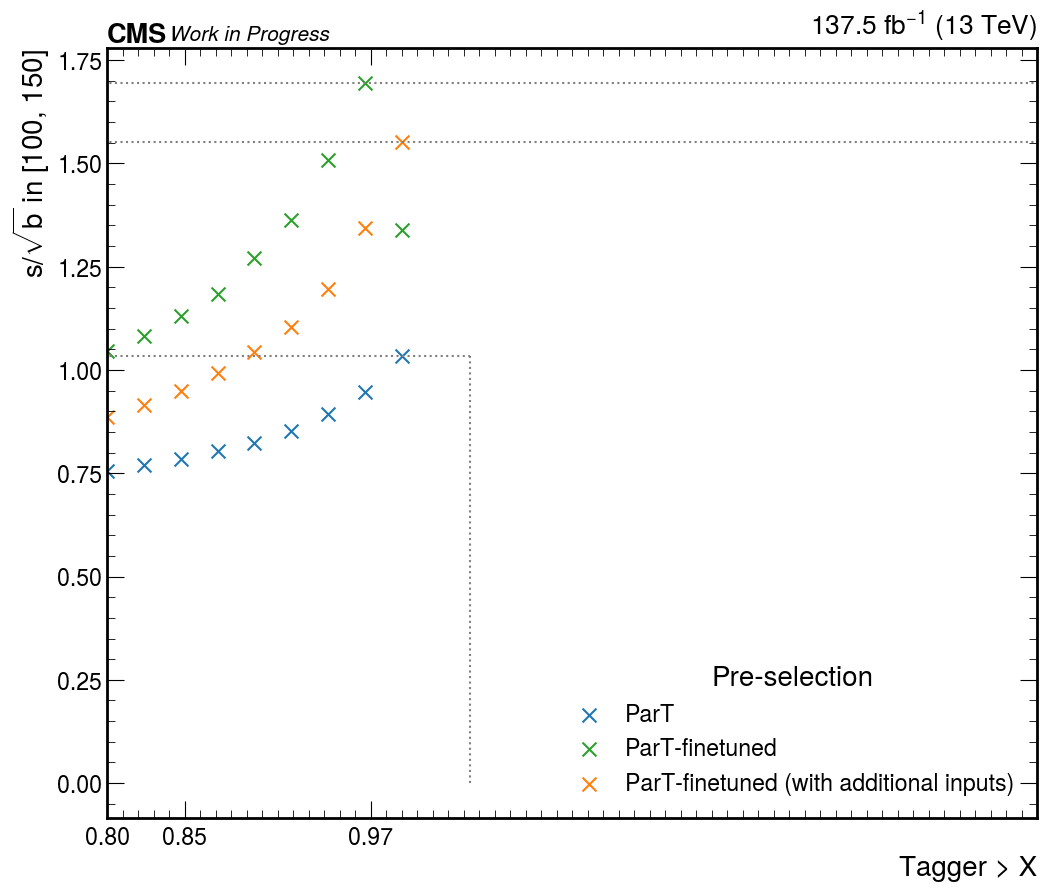

In [185]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",    
    "fj_ParT_score_finetuned_v2-1111-10noMass1": "tab:red",        
    "fj_ParT_score_finetuned_v2_1-12": "tab:orange",                   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
    "fj_ParT_score_finetuned_v2-1111-10noMass1":  "ParT-finetuned (with external inputs)",
    "fj_ParT_score_finetuned_v2_1-12": "ParT-finetuned (with additional inputs)",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))

for tagger in taggers:
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])

# ax.axvline(0.97, color="grey", linestyle="--", label="WP1=0.97")
    
    maxsoverb = float(max(s_over_b[tagger]))
    

    ax.plot([0, maxsoverb], [maxsoverb, maxsoverb], ':', color='grey')
    ax.plot([maxsoverb, maxsoverb], [0, maxsoverb], ':', color='grey')

#     break
    
# ax.set_ylim(1.25, 2.25)
ax.set_xlim(0.8, 1.4)

ax.legend(title="Pre-selection")
ax.set_ylabel(r"$s/\sqrt{b}$ in " + f"[{mass_window[0]}, {mass_window[1]}]");
ax.set_xlabel(r"Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])
ax.set_xticks([0.8, 0.85, 0.97])

hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/tagger.pdf")

In [ ]:
    regions = ["SR1VBF", "SR1ggpt300to450", "SR1ggFpt450toInf", "SR2"]  # put the signal regions here
    for region in regions:
        regions += [f"{region}Blinded"]

    for region in regions:
        if wjets_estimation:
            regions += [f"WJetsCRfor{region}"]
        if top_estimation:
            regions += [f"TopCRfor{region}"]

In [193]:
    regions = ["SR1VBF", "SR1ggpt300to450", "SR1ggFpt450toInf", "SR2"]  # put the signal regions here
    for region in regions.copy():
        print(region)
        regions += [f"{region}Blinded"]

In [191]:
regions

In [192]:
regions

In [169]:
[tagger_cuts[np.argmax(np.array(s_over_b[tagger]))], float(max(s_over_b[tagger]))], [0, float(max(s_over_b[tagger]))]

([0.99, 1.034], [0, 1.034])

In [147]:
[0, float(max(s_over_b[tagger]))]

[0, 1.55]

In [69]:
wp1 = 0.97
        
tagger_cuts = np.linspace(0.7, 0.97, 28)

mass_window = [80, 160]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]

s_over_b = {}

# taggers = ["fj_ParT_score", "fj_ParT_score_finetuned", "fj_ParT_score_finetuned_v2_1-12"]
taggers = ["fj_ParT_score", "fj_ParT_score_finetuned"]

for tagger in taggers:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample=="Data":
                        continue

                    df = events_dict[year][ch][sample]   # doesnt include low pt bin
                    
                    df = df[df[tagger]>tagger_cut]
        
                    # add inverted tagger cut
                    df = df[df[tagger]<wp1]                        

                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97
TAGGER: fj_ParT_score_finetuned
tagger cut 0.7


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_15173/137622231.py:45: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b[tagger].append(s/math.sqrt(b))


tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


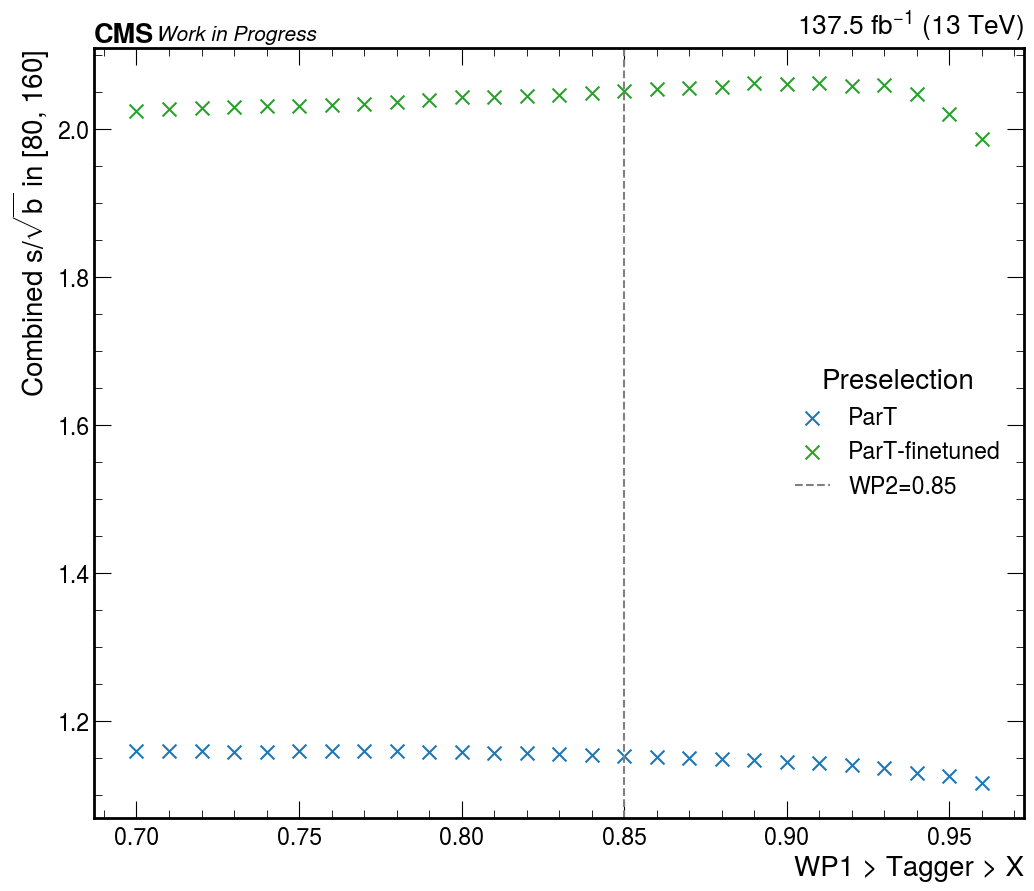

In [70]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",    
    "fj_ParT_score_finetuned_v2-1111-10noMass1": "tab:red",        
    "fj_ParT_score_finetuned_v2_1-12": "tab:orange",                   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
    "fj_ParT_score_finetuned_v2-1111-10noMass1":  "ParT-finetuned (with external inputs)",
    "fj_ParT_score_finetuned_v2_1-12": "ParT-finetuned (with additional inputs)",
}


plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(12, 10))

for tagger in taggers:
    if tagger == "fj_ParT_score_finetuned":
        soverb_high = 1.9
    elif tagger == "fj_ParT_score":
        soverb_high = 1.1
    
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.85, color="grey", linestyle="--", label="WP2=0.85")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Preselection")
ax.set_ylabel(r"Combined $s/\sqrt{b}$ in " + f"[{mass_window[0]}, {mass_window[1]}]");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"WP1 > Tagger > X")
# ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/tagger_soverb_WP2.pdf")

In [71]:
wp2 = 0.85
        
tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

mass_window = [80, 160]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]

s_over_b = {}

# taggers = ["fj_ParT_score", "fj_ParT_score_finetuned", "fj_ParT_score_finetuned_v2_1-12"]
taggers = ["fj_ParT_score", "fj_ParT_score_finetuned"]

for tagger in taggers:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample=="Data":
                        continue

                    df = events_dict[year][ch][sample]   # doesnt include low pt bin
                    
                    df = df[df[tagger]>tagger_cut]
        
                    # add inverted tagger cut
                    df = df[df[tagger]<wp2]                        

                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.025
tagger cut 0.05
tagger cut 0.075
tagger cut 0.1
tagger cut 0.15
tagger cut 0.2
tagger cut 0.25
tagger cut 0.3
tagger cut 0.35
tagger cut 0.4
tagger cut 0.45
tagger cut 0.5
tagger cut 0.55
tagger cut 0.6
tagger cut 0.65
tagger cut 0.7
tagger cut 0.75
tagger cut 0.8
TAGGER: fj_ParT_score_finetuned
tagger cut 0.025
tagger cut 0.05
tagger cut 0.075
tagger cut 0.1
tagger cut 0.15
tagger cut 0.2
tagger cut 0.25
tagger cut 0.3
tagger cut 0.35
tagger cut 0.4
tagger cut 0.45
tagger cut 0.5
tagger cut 0.55
tagger cut 0.6
tagger cut 0.65
tagger cut 0.7
tagger cut 0.75
tagger cut 0.8


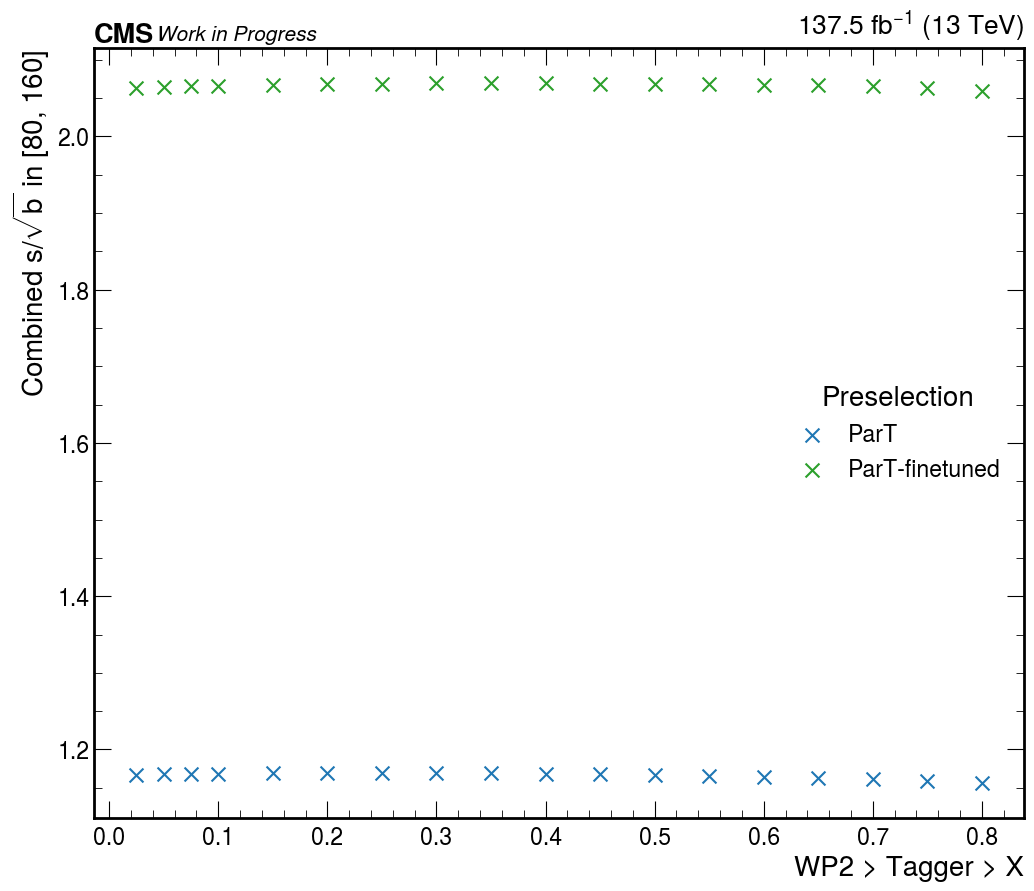

In [72]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",    
    "fj_ParT_score_finetuned_v2-1111-10noMass1": "tab:red",        
    "fj_ParT_score_finetuned_v2_1-12": "tab:orange",                   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
    "fj_ParT_score_finetuned_v2-1111-10noMass1":  "ParT-finetuned (with external inputs)",
    "fj_ParT_score_finetuned_v2_1-12": "ParT-finetuned (with additional inputs)",
}


plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(12, 10))

for tagger in taggers:
    if tagger == "fj_ParT_score_finetuned":
        soverb_high = 2.05
    elif tagger == "fj_ParT_score":
        soverb_high = 1.15
    
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

# ax.axvline(0.85, color="grey", linestyle="--", label="WP2=0.85")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Preselection")
ax.set_ylabel(r"Combined $s/\sqrt{b}$ in " + f"[{mass_window[0]}, {mass_window[1]}]");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"WP2 > Tagger > X")
# ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/tagger_soverb_WP3.pdf")

In [67]:
(1.9**2 + 0.76**2)**0.5

2.0463626267111117